In [1]:
from __future__ import print_function

import sys
import os
sys.path.insert(0, os.path.join(os.pardir, 'sparat'))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin
import seaborn as sns
import statsmodels.api as sm

from data_processing.rat import load_rat_items
from data_processing.generate_association_matrix import load_assoc_mat
from data_processing.spgen import load_pointers
from model.stimulus import filter_valid
from data_processing.spgen import load_pointers

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Load experimental data

In [2]:
basedir = os.pardir
path_file = os.path.join(basedir, 'data', 'raw', '144CompoundBowden.xlsx')
xls = pd.ExcelFile(path_file)

Load the excel sheet with values from the paper and sort RAT problems according to the t=2 condition:

In [3]:
df = xls.parse('RAT stimuli part1.csv', skip_footer=2)
df.columns = [
    'items', 'solution', '2s-%',
    '7s-%',  '7s-t-mean', '7s-t-sd',
    '15s-%', '15s-t-mean', '15s-t-sd',
    '30s-%', '30s-t-mean', '30s-t-sd']
df = df.sort_values('2s-%', ascending=False)
df = df.set_index(np.arange(len(df)))

## Load association data

In [4]:
def pointers2assoc(pointers, i2w, w2i):
    return np.dot(pointers, pointers.T), i2w, w2i

In [5]:
datasets = {
        k: load_assoc_mat(os.path.join(basedir, 'data', 'associationmatrices'), k)
        for k in ['freeassoc_asymmetric', 'freeassoc_symmetric', 'google_symmetric']
    }

In [6]:
datasets.update({
        k: pointers2assoc(*load_pointers(os.path.join(basedir, 'data', 'semanticpointers'), k))
        for k in [
            'freeassoc_symmetric_svd_factorize_5018w_512d',
            'google_symmetric_svd_factorize_5018w_768d'
        ]
    })

In [7]:
pointers, i2w, w2i = load_pointers(
    os.path.join(basedir, 'data', 'semanticpointers'),
    'freeassoc_asymmetric_randomize_orthonormal_5018w_5120d')
assoc = datasets['freeassoc_asymmetric'][0]
pointers_sq = np.dot(pointers, pointers.T)
datasets['neural'] = (np.dot(pointers_sq, np.dot(assoc, pointers_sq)), i2w, w2i)

In [8]:
def solve_p(row, assoc, i2w, w2i, ws=(1., 1., 1.)):
    '''
    Compute probabilities for each row based on associations and store the result in col_title.
    '''
    assert len(ws) == 3
    beta = ws[-1]
    alphas = (1., ws[0], ws[1])
    
    cues = row['items'].upper().split('/')
    target = row['solution'].upper()
    
    if not all(w in i2w for w in cues+[target]):
        return np.nan
    else:
        strengths = np.sum([alphas[i]*assoc[w2i[cue], :] for i, cue in enumerate(cues)], axis=0)
        for cue in cues:
            strengths[w2i[cue]] = 0.
        normed = strengths / np.sum(strengths)
        return beta * 100 * normed[w2i[target]]

In [9]:
def model(params, assoc, i2w, w2i):
    x = df.apply(solve_p, args=(assoc, i2w, w2i, params), axis=1).dropna()
    y = df.loc[x.index]
    return np.sqrt(np.sum(np.square(x - y['2s-%'])))

In [10]:
fits = {
        k: fmin(model, (1., 1., 1.), assoc)
        for k, assoc in datasets.items()
    }

Optimization terminated successfully.
         Current function value: 79.912015
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 79.912015
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 109.394763
         Iterations: 142
         Function evaluations: 253
Optimization terminated successfully.
         Current function value: 80.122523
         Iterations: 129
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 82.733698
         Iterations: 89
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 103.383995
         Iterations: 125
         Function evaluations: 220


In [11]:
fits

{'freeassoc_asymmetric': array([ 2.05991529,  1.19931146,  1.13050399]),
 'freeassoc_symmetric': array([ 2.49525947,  1.63290787,  2.85911463]),
 'freeassoc_symmetric_svd_factorize_5018w_512d': array([ 3.22113594,  1.656956  ,  7.39585901]),
 'google_symmetric': array([ 13.4493152 ,   1.25004022,   3.54983852]),
 'google_symmetric_svd_factorize_5018w_768d': array([ 12.38486251,   0.94904785,   8.1696444 ]),
 'neural': array([ 2.05991529,  1.19931146,  1.13050399])}

In [12]:
def model_r(params, assoc, i2w, w2i):
    x = df.apply(solve_p, args=(assoc, i2w, w2i, params), axis=1).dropna()
    y = df.loc[x.index]
    return sm.OLS(x, y['2s-%']).fit().rsquared

r_values = {k: model_r(v, *datasets[k]) for k, v in fits.items()}
r_values

{'freeassoc_asymmetric': 0.58193583237955693,
 'freeassoc_symmetric': 0.57973036097046127,
 'freeassoc_symmetric_svd_factorize_5018w_512d': 0.55189100719134609,
 'google_symmetric': 0.30027820830522056,
 'google_symmetric_svd_factorize_5018w_768d': 0.21654899741141376,
 'neural': 0.58193583237955271}

In [13]:
table = r'''
\begin{{tabular}}{{lrrrrr}} \toprule
Association matrix & $\alpha_1$ & $\alpha_2$ & $\alpha_3$ & $\beta$ & $r^2$ \\ \midrule
\fanasym{{}} & 1.0 & {fanasym} \\
\fansym{{}} & 1.0 & {fansym} \\
\ngsym{{}} & 1.0 & {ngsym4096} \\
\ngsym[768] & 1.0 & {ngsym768} \\
\bottomrule
\end{{tabular}}
'''.format(
    fanasym=' & '.join(r"\num{{{:.2f}}}".format(x)  for x in list(fits['freeassoc_asymmetric']) + [r_values['freeassoc_asymmetric']]),
    fansym=' & '.join(r"\num{{{:.2f}}}".format(x) for x in list(fits['freeassoc_symmetric']) + [r_values['freeassoc_symmetric']]),
    ngsym4096=' & '.join(r"\num{{{:.2f}}}".format(x) for x in
        list(fits['google_symmetric']) +
        [r_values['google_symmetric']]),
    ngsym768=' & '.join(r"\num{{{:.2f}}}".format(x) for x in
        list(fits['google_symmetric_svd_factorize_5018w_768d']) + 
        [r_values['google_symmetric_svd_factorize_5018w_768d']]))

In [14]:
with open(os.path.join(basedir, 'rvalues.tex'), 'wt') as f:
    f.write(table)

## Plot

In [15]:
sns.set('paper', 'ticks')

column_width_pt = 243.91125
pt2inch = 1. / 72.27
column_width_inch = pt2inch * column_width_pt

In [16]:
p = df['2s-%'] / 100.
n = 89
z = 1.96
ci = 100 * 1.96 * np.sqrt(p * (1 - p) / float(n))
lci, uci = df['2s-%'] - ci, df['2s-%'] + ci

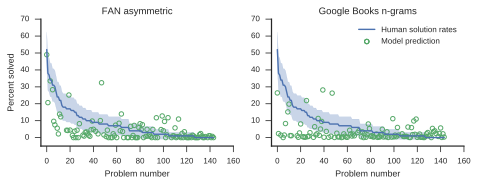

In [17]:
%matplotlib inline
colors = sns.color_palette(n_colors=2)
titles = {
    #'freeassoc_symmetric': "FAN symmetric",
    'freeassoc_asymmetric': "FAN asymmetric",
    'google_symmetric': "Google Books n-grams",
    #'freeassoc_symmetric_svd_factorize_5018w_512d': "FAN symmetric 512d",
    #'google_symmetric_svd_factorize_5018w_4096d': "Google Books n-grams, 4096 dimensions"
}
toplot = ['freeassoc_asymmetric', 'google_symmetric']

fig = plt.figure(figsize=(2 * column_width_inch, 0.8 * column_width_inch))

ax = None
for i, k in enumerate(toplot):
    ax = fig.add_subplot(1, len(toplot), i + 1, sharex=ax)
    ax.plot(df['2s-%'].values, c=colors[0], label='Human solution rates')
    ax.fill_between(np.arange(len(df)), lci, uci, alpha=0.3, color=colors[0])
    ax.scatter(np.arange(len(df)), df.apply(solve_p, args=datasets[k] + (fits[k],), axis=1), 
               linewidths=1, edgecolors=colors[1], c=(1, 1, 1, 0), marker='o',
              label='Model prediction')
    
    ax.set_title(titles[k])
    ax.set_xlabel('Problem number')
    if i <= 0:
        ax.set_ylabel("Percent solved")
    
    ax.set_xlim(left=-5)
    ax.set_ylim(bottom=-5)
    
plt.legend()
sns.despine()
fig.tight_layout()

In [18]:
fig.savefig(os.path.join(basedir, 'fit.pdf'))

## Error analysis

This is a first-approximation of error analysis, since the model is fairly simple and we are not really trying to account for any more things than accuracy matching. Therefore, to see which method is getting problems right/wrong as humans do, we take a set of easier problems and a set of harder problems and see how every method scores for those.

More specifically we been by the human solution rates in a way that we have at least 10 problems in each bin (this leads to a varying bin size) to be able to at least get an rough estimate of confidence intervals for the error.

In [19]:
df['fa_p'] = df.apply(solve_p, args=datasets['freeassoc_asymmetric'] + (fits['freeassoc_asymmetric'],), axis=1)
df['gn_p'] = df.apply(solve_p, args=datasets['google_symmetric'] + (fits['google_symmetric'],), axis=1)

df['fa_err'] = df['fa_p'] - df['2s-%']
df['gn_err'] = df['gn_p'] - df['2s-%']

In [20]:
n_elements_per_bin = 10

bins = [0.]
element_counts = []
for i in range(100):
    n_elements = ((df['2s-%'] >= bins[-1]) & (df['2s-%'] < i)).sum()
    if n_elements > n_elements_per_bin:
        element_counts.append(n_elements)
        bins.append(float(i))
        
print(bins)
print(element_counts)

[0.0, 1.0, 2.0, 3.0, 5.0, 8.0, 10.0, 13.0, 18.0, 32.0]
[17, 22, 13, 21, 18, 14, 11, 11, 12]


In [21]:
df['bin'] = np.digitize(df['2s-%'].values, bins)

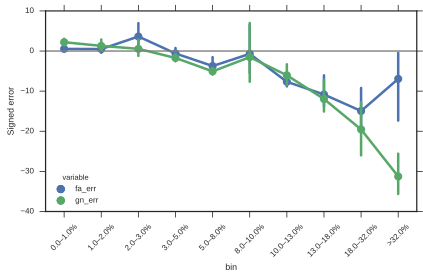

In [22]:
sns.pointplot('bin', 'value', 'variable', data=pd.melt(df, id_vars=['bin'], value_vars=['fa_err', 'gn_err']))
plt.axhline(y=0, c=(0.5, 0.5, 0.5))
plt.ylabel("Signed error")
plt.xticks(
    range(len(bins)),
    [u"{}–{}%".format(bins[i], bins[i+1]) for i in range(len(bins) - 1)] + [">{}%".format(bins[-1])],
    rotation=45)
plt.tight_layout()

The Google n-gram approach clearly underestimates the solution probabilities compared to the FAN approach. It seems that it also slightly overestimates solution probabilities for problems that are almost never solved in 2s. If we generally get the Google n-grams approach to predict higher solution probabilities to account for the first problem, it will likely even more overestimate the solution probabilities of the hard problems. Thus, the FAN provide a better match to human data.